# **BEERS ANALYSIS**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import re
import math
from scipy import stats
import seaborn as sns
from src.data.utils import *
from src.data.utils import dataset_information
from scipy.stats import trim_mean
import plotly.express as px
import geopandas as gpd

# Files loading

In [2]:
beers_rate = pd.read_csv("data/Processed/RateBeer/beers_processed.csv", sep=",")
beers_adv = pd.read_csv("data/Processed/BeerAdvocate/beers_processed.csv", sep=",")

C:\Users\jon\AppData\Local\Temp\ipykernel_11072\2943317526.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  beers_rate = pd.read_csv("data/Processed/RateBeer/beers_processed.csv", sep=",")


# Initial analysis

## Possible merging of both datasets

In [3]:
print(dataset_information(beers_rate, "BeersRB"))



########################################################
We are starting analysing dataset BeersRB
- Dimension of starting dataset: (396631, 20)
- Columns of dataset:  Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'overall_score', 'style_score', 'avg', 'abv',
       'avg_computed', 'zscore', 'nbr_matched_valid_ratings',
       'avg_matched_valid_ratings', 'brewery_name_y', 'location',
       'location_region', 'US', 'UK', 'Canada'],
      dtype='object')
- Are all the id unique? Answer: True
- Are there some values that are NaN inside the dataset? Answer: True
Head: 
    beer_id               beer_name  brewery_id      brewery_name  \
0   410549       33 Export (Gabon)        3198           Sobraga   
1   105273     Castel Beer (Gabon)        3198           Sobraga   
2    19445                   Régab        3198           Sobraga   
3   155699  Ards Bally Black Stout       13538  Ards Brewing Co.   
4   239097        Ards Belfast 366   

In [4]:
print(dataset_information(beers_adv, "BeersBA"))



########################################################
We are starting analysing dataset BeersBA
- Dimension of starting dataset: (247488, 20)
- Columns of dataset:  Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'nbr_reviews', 'avg', 'ba_score', 'bros_score', 'abv',
       'avg_computed', 'zscore', 'nbr_matched_valid_ratings',
       'avg_matched_valid_ratings', 'location', 'location_region', 'US', 'UK',
       'Canada'],
      dtype='object')
- Are all the id unique? Answer: True
- Are there some values that are NaN inside the dataset? Answer: True
Head: 
    beer_id           beer_name  brewery_id  \
0   142544               Régab       37262   
1    19590       Barelegs Brew       10093   
2    19827            Legbiter       10093   
3    20841   St. Patrick's Ale       10093   
4    20842  St. Patrick's Best       10093   

                                brewery_name             style  nbr_ratings  \
0  Societe des Brasseries du G

There is some clear work needed in columns data handling:

* `nbr_reviews`: this variable is not present in BeerAdvocate.
* numerical overall: there are several values (`avg`,`overall_score`,`bros_score`,`style_score`,`ba_score`) that are not present in both datasets and some are full of NaN values.

Let's start by retaining only common columns.

In [5]:
print("Common columns between the two datasets:")
common_beers_cols = set(beers_rate.columns).intersection(set(beers_adv.columns))
print(common_beers_cols)

Common columns between the two datasets:
{'location', 'beer_id', 'brewery_name', 'location_region', 'brewery_id', 'avg_matched_valid_ratings', 'US', 'avg', 'Canada', 'avg_computed', 'nbr_matched_valid_ratings', 'beer_name', 'zscore', 'abv', 'UK', 'nbr_ratings', 'style'}


In [6]:
beers_rate_col_filt = beers_rate[list(common_beers_cols)]
beers_adv_col_filt = beers_adv[list(common_beers_cols)]

desired_order = [
    'beer_id','beer_name',
    'brewery_id','brewery_name',
    'style','abv',
    'nbr_ratings','avg','avg_computed','avg_matched_valid_ratings','zscore','nbr_matched_valid_ratings',
    'location', 'location_region','US', 'UK', 'Canada'
]

beers_rate_col_filt = beers_rate_col_filt[desired_order]
beers_adv_col_filt = beers_adv_col_filt[desired_order]

In [7]:
beers_rate_col_filt.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,abv,nbr_ratings,avg,avg_computed,avg_matched_valid_ratings,zscore,nbr_matched_valid_ratings,location,location_region,US,UK,Canada
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,5.0,1,2.72,2.000000,NaN,NaN,0,Gabon,NaN,False,False,False
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,5.2,10,2.18,1.910000,NaN,NaN,0,Gabon,NaN,False,False,False
2,19445,Régab,3198,Sobraga,Pale Lager,4.5,27,1.83,1.811111,NaN,NaN,0,Gabon,NaN,False,False,False
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,4.6,6,3.18,3.866667,3.866667,0.823699,6,United Kingdom,Northern Ireland,False,True,False
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,4.2,1,2.79,3.000000,NaN,NaN,0,United Kingdom,Northern Ireland,False,True,False


In [8]:
beers_adv_col_filt.head(5)

,beer_id,beer_name,brewery_id,brewery_name,style,abv,nbr_ratings,avg,avg_computed,avg_matched_valid_ratings,zscore,nbr_matched_valid_ratings,location,location_region,US,UK,Canada
0,142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),Euro Pale Lager,4.5,1,2.88,2.880000,NaN,NaN,0,Gabon,NaN,False,False,False
1,19590,Barelegs Brew,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4.5,4,3.85,3.845000,NaN,NaN,0,United Kingdom,Northern Ireland,False,True,False
2,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4.8,75,3.45,3.439867,3.504068,-0.649167,59,United Kingdom,Northern Ireland,False,True,False
3,20841,St. Patrick's Ale,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,6.0,8,3.86,3.888750,3.768333,0.093110,6,United Kingdom,Northern Ireland,False,True,False
4,20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,English Bitter,4.2,64,3.56,3.556094,3.580417,-0.478579,48,United Kingdom,Northern Ireland,False,True,False


Investigation of numerical variables distributions:

In [9]:
numeric_cols_rate = beers_rate_col_filt.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_adv = beers_adv_col_filt.select_dtypes(include=['float64', 'int64']).columns

nan_rate = beers_rate_col_filt[numeric_cols_rate].isna().mean() * 100
nan_adv = beers_adv_col_filt[numeric_cols_adv].isna().mean() * 100

nan_rate_df = pd.DataFrame({'Column': nan_rate.index, 'NaN Percentage (Rate)': nan_rate.values})
nan_adv_df = pd.DataFrame({'Column': nan_adv.index, 'NaN Percentage (Adv)': nan_adv.values})

In [10]:
nan_adv_df

,Column,NaN Percentage (Adv)
0,beer_id,0.000000
1,brewery_id,0.000000
2,abv,12.404238
3,nbr_ratings,0.000000
4,avg,0.000000
5,avg_computed,0.000000
6,avg_matched_valid_ratings,88.576416
7,zscore,83.722443
8,nbr_matched_valid_ratings,0.000000


In [11]:
nan_rate_df

,Column,NaN Percentage (Rate)
0,beer_id,0.000000
1,brewery_id,0.000000
2,abv,9.259488
3,nbr_ratings,0.000000
4,avg,0.262965
5,avg_computed,0.000000
6,avg_matched_valid_ratings,89.353328
7,zscore,89.353328
8,nbr_matched_valid_ratings,0.000000


We can see how `avg_matched_valid_ratings` and `zscore` need to be left out clearly, while the others present null or really low value of NaN presence:

In [12]:
columns_to_drop = ['avg_matched_valid_ratings', 'zscore']
beers_rate_col_filt = beers_rate_col_filt.drop(columns=columns_to_drop, errors='ignore')
beers_adv_col_filt = beers_adv_col_filt.drop(columns=columns_to_drop, errors='ignore')

beers_rate_col_filt = beers_rate_col_filt.dropna(subset=['avg', 'abv'])
beers_adv_col_filt = beers_adv_col_filt.dropna(subset=['avg', 'abv'])

In [13]:
beers_rate_col_filt.head()

,beer_id,beer_name,brewery_id,brewery_name,style,abv,nbr_ratings,avg,avg_computed,nbr_matched_valid_ratings,location,location_region,US,UK,Canada
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,5.0,1,2.72,2.000000,0,Gabon,NaN,False,False,False
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,5.2,10,2.18,1.910000,0,Gabon,NaN,False,False,False
2,19445,Régab,3198,Sobraga,Pale Lager,4.5,27,1.83,1.811111,0,Gabon,NaN,False,False,False
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,4.6,6,3.18,3.866667,6,United Kingdom,Northern Ireland,False,True,False
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,4.2,1,2.79,3.000000,0,United Kingdom,Northern Ireland,False,True,False


In [14]:
beers_adv_col_filt.head()

,beer_id,beer_name,brewery_id,brewery_name,style,abv,nbr_ratings,avg,avg_computed,nbr_matched_valid_ratings,location,location_region,US,UK,Canada
0,142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),Euro Pale Lager,4.5,1,2.88,2.880000,0,Gabon,NaN,False,False,False
1,19590,Barelegs Brew,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4.5,4,3.85,3.845000,0,United Kingdom,Northern Ireland,False,True,False
2,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4.8,75,3.45,3.439867,59,United Kingdom,Northern Ireland,False,True,False
3,20841,St. Patrick's Ale,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,6.0,8,3.86,3.888750,6,United Kingdom,Northern Ireland,False,True,False
4,20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,English Bitter,4.2,64,3.56,3.556094,48,United Kingdom,Northern Ireland,False,True,False


Now that we have filtered all columns, lets investigate wether `avg` could be a valid representation of score:

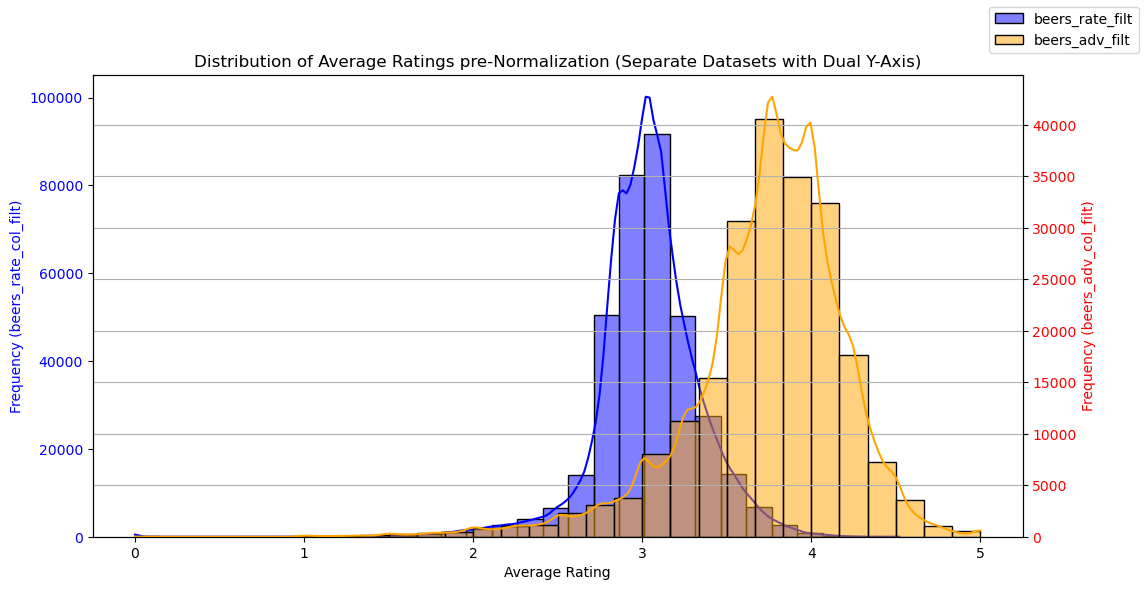

In [15]:
fig, ax1 = plt.subplots(figsize=(12, 6))
    
sns.histplot(beers_rate_col_filt['avg'], bins=30, kde=True, color='blue', alpha=0.5, ax=ax1, label='beers_rate_filt')
ax1.set_xlabel('Average Rating')
ax1.set_ylabel('Frequency (beers_rate_col_filt)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
    
ax2 = ax1.twinx()
sns.histplot(beers_adv_col_filt['avg'], bins=30, kde=True, color='orange', alpha=0.5, ax=ax2, label='beers_adv_filt')
ax2.set_ylabel('Frequency (beers_adv_col_filt)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
    
plt.title('Distribution of Average Ratings pre-Normalization (Separate Datasets with Dual Y-Axis)')
fig.legend(loc='upper right')
plt.grid(True)
plt.show()

In [16]:
shapiro_stat, shapiro_p = stats.shapiro(beers_rate_col_filt['avg'])
print(f"Shapiro-Wilk Test Statistic in RateBeer: {shapiro_stat}, p-value: {shapiro_p}")
if shapiro_p > 0.05:
    print("The 'avg' values are likely normally distributed (fail to reject H0).")
else:
    print("The 'avg' values are not normally distributed (reject H0).")

    shapiro_stat, shapiro_p = stats.shapiro(beers_adv_col_filt['avg'])
print(f"\nShapiro-Wilk Test Statistic in BeerAdvocate: {shapiro_stat}, p-value: {shapiro_p}")
if shapiro_p > 0.05:
    print("The 'avg' values are likely normally distributed (fail to reject H0).")
else:
    print("The 'avg' values are not normally distributed (reject H0).")

Shapiro-Wilk Test Statistic in RateBeer: 0.9365990663595944, p-value: 1.5444472537912344e-124
The 'avg' values are not normally distributed (reject H0).

Shapiro-Wilk Test Statistic in BeerAdvocate: 0.9362437340951902, p-value: 1.3641631722575046e-115
The 'avg' values are not normally distributed (reject H0).


c:\Users\jon\anaconda3\envs\ada\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 358961.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\jon\anaconda3\envs\ada\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 216789.
  res = hypotest_fun_out(*samples, **kwds)


Let's normalize the `avg` rating:

In [17]:
beers_adv_col_filt['avg'] =  beers_adv_col_filt['avg']/ beers_adv_col_filt['avg'].max()
beers_rate_col_filt['avg'] =  beers_rate_col_filt['avg']/ beers_rate_col_filt['avg'].max()

shapiro_stat, shapiro_p = stats.shapiro(beers_rate_col_filt['avg'])
print(f"Shapiro-Wilk Test Statistic in RateBeer: {shapiro_stat}, p-value: {shapiro_p}")
if shapiro_p > 0.05:
    print("The 'avg' values are likely normally distributed (fail to reject H0).")
else:
    print("The 'avg' values are not normally distributed (reject H0).")

    shapiro_stat, shapiro_p = stats.shapiro(beers_adv_col_filt['avg'])
print(f"\nShapiro-Wilk Test Statistic in BeerAdvocate: {shapiro_stat}, p-value: {shapiro_p}")
if shapiro_p > 0.05:
    print("The 'avg' values are likely normally distributed (fail to reject H0).")
else:
    print("The 'avg' values are not normally distributed (reject H0).")

Shapiro-Wilk Test Statistic in RateBeer: 0.9365990663595948, p-value: 1.54444725379185e-124
The 'avg' values are not normally distributed (reject H0).

Shapiro-Wilk Test Statistic in BeerAdvocate: 0.9362437340951902, p-value: 1.3641631722575046e-115
The 'avg' values are not normally distributed (reject H0).


`avg` cannot be considered as normally distributed even after normalization over the maximum value:

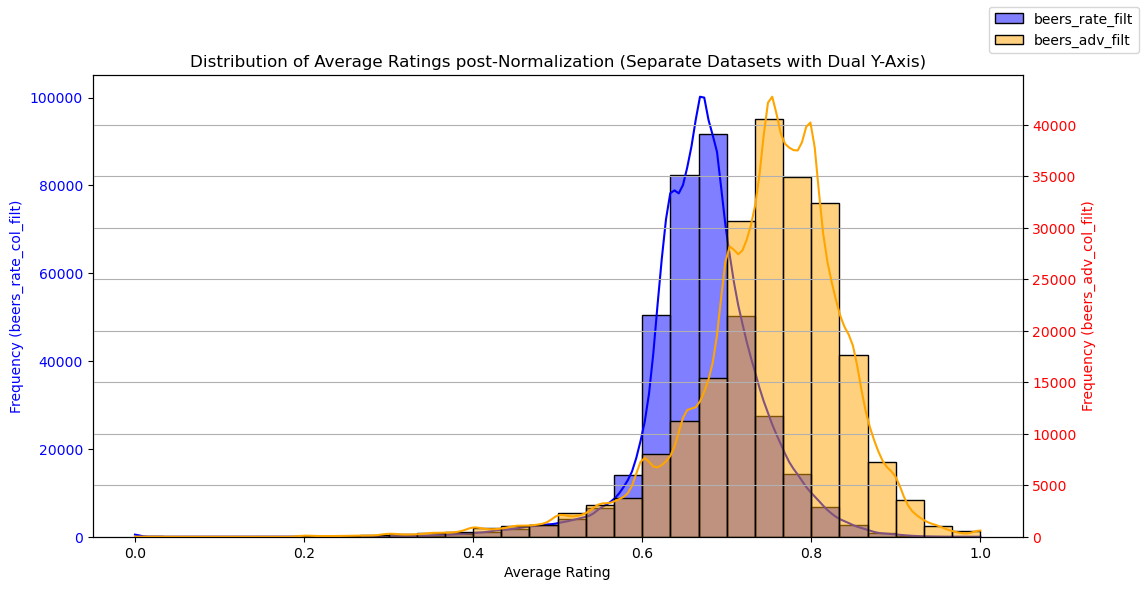

In [18]:
fig, ax1 = plt.subplots(figsize=(12, 6))
    
sns.histplot(beers_rate_col_filt['avg'], bins=30, kde=True, color='blue', alpha=0.5, ax=ax1, label='beers_rate_filt')
ax1.set_xlabel('Average Rating')
ax1.set_ylabel('Frequency (beers_rate_col_filt)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
    
ax2 = ax1.twinx()
sns.histplot(beers_adv_col_filt['avg'], bins=30, kde=True, color='orange', alpha=0.5, ax=ax2, label='beers_adv_filt')
ax2.set_ylabel('Frequency (beers_adv_col_filt)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
    
plt.title('Distribution of Average Ratings post-Normalization (Separate Datasets with Dual Y-Axis)')
fig.legend(loc='upper right')
plt.grid(True)
plt.show()

This can also be seen via Q-Q plots:

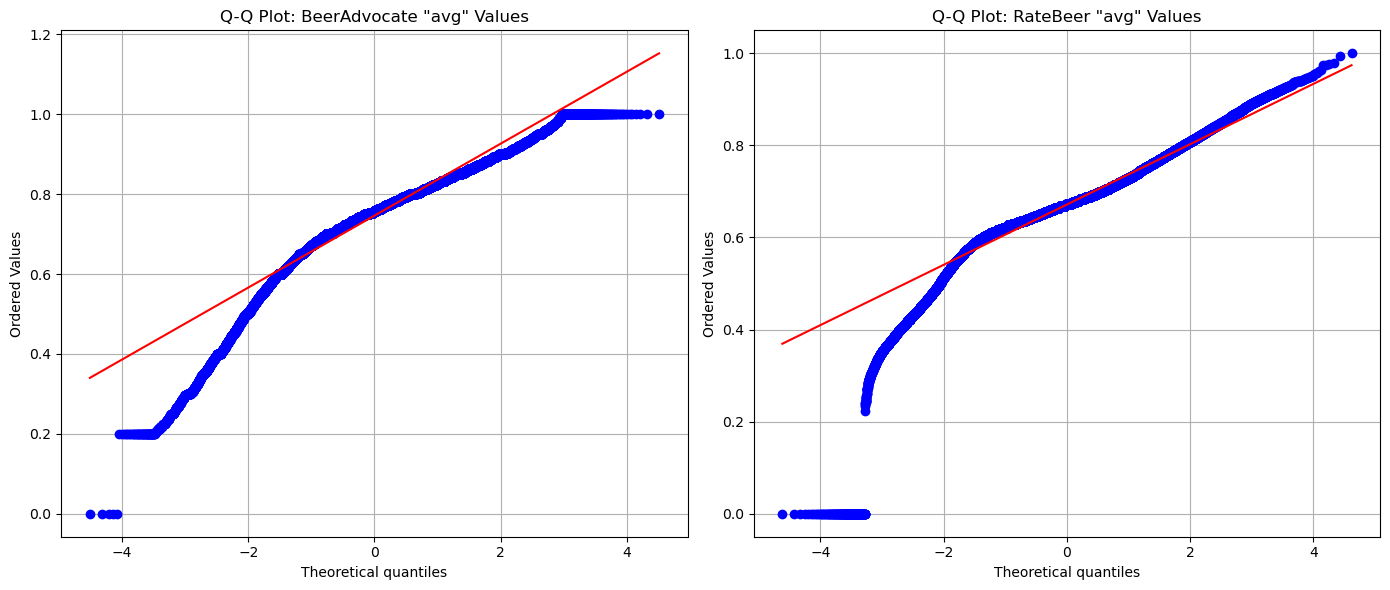

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

stats.probplot(beers_adv_col_filt['avg'], dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot: BeerAdvocate "avg" Values')
ax1.grid(True)

stats.probplot(beers_rate_col_filt['avg'], dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot: RateBeer "avg" Values')
ax2.grid(True)

plt.tight_layout()
plt.show()

There is a noticeable S-shape pattern, indicating that the distribution has heavier tails and is likely skewed. The points in the lower left and upper right corners show substantial divergence from the normal distribution, suggesting the presence of outliers or extreme values.

In [20]:
print(beers_rate_col_filt['avg'].describe())
print(beers_adv_col_filt['avg'].describe())

count    358961.000000
mean          0.671709
std           0.067671
min           0.000000
25%           0.637168
50%           0.672566
75%           0.705752
max           1.000000
Name: avg, dtype: float64
count    216789.000000
mean          0.746419
std           0.093052
min           0.000000
25%           0.702000
50%           0.758000
75%           0.802000
max           1.000000
Name: avg, dtype: float64


Evaluation of possible difference in `avg` across same beers:

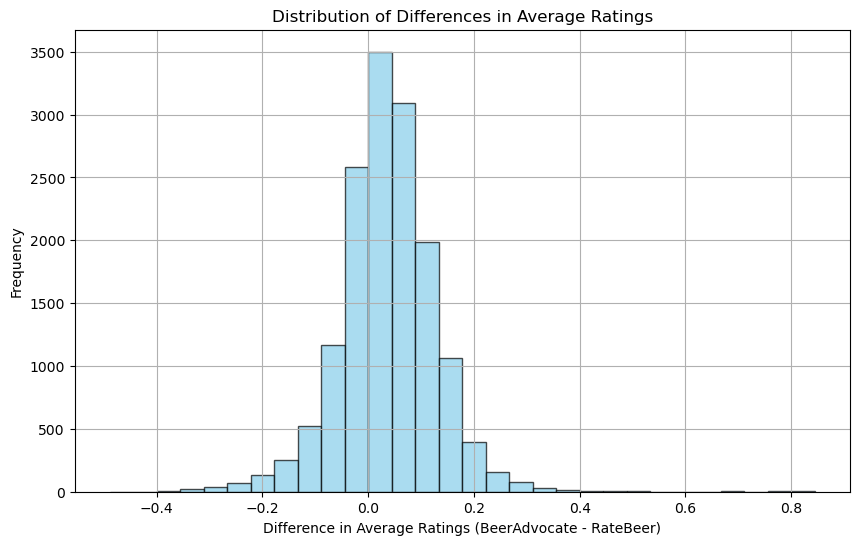

Paired t-test results: t-statistic = 48.5882, p-value = 0.0000
Wilcoxon signed-rank test results: statistic = 29981097.5000, p-value = 0.0000


In [21]:
avg_cross = pd.merge(
    beers_adv_col_filt[['beer_name', 'avg']],
    beers_rate_col_filt[['beer_name', 'avg']],
    on='beer_name',
    suffixes=('_adv', '_rate')
)

avg_cross['rating_diff'] = avg_cross['avg_adv'] - avg_cross['avg_rate']

plt.figure(figsize=(10, 6))
plt.hist(avg_cross['rating_diff'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Differences in Average Ratings')
plt.xlabel('Difference in Average Ratings (BeerAdvocate - RateBeer)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

t_stat, p_value = stats.ttest_rel(avg_cross['avg_adv'], avg_cross['avg_rate'])
print(f"Paired t-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

wilcoxon_stat, wilcoxon_p = stats.wilcoxon(avg_cross['avg_adv'], avg_cross['avg_rate'])
print(f"Wilcoxon signed-rank test results: statistic = {wilcoxon_stat:.4f}, p-value = {wilcoxon_p:.4f}")

We can see above how the mean of differences lies at zero range, suggesting that similar beers are being ranked similar in both RateBeer and BeerAdvocate. Although the two clear peaks of most frequent rating are still very different. 

Computation of the `style_score`. Is the beer's overall score based on its ranking within its style category. It's based on the beer's truncated (trimmed) mean and a custom Bayesian (weighted rank) formula that takes the beer's style into consideration. Its purpose is to provide consumers with a quick reference using a format that's familiar to the wine and liquor worlds:

Style score Range:

* 95-100 = world-class
* 90-94 = outstanding
* 85-89 = very good
* 80-84 = good
* 70-79 = okay
* 60-69 = poor
* < 60 = awful

In [22]:
beers_adv_col_filt['avg_scaled'] = beers_adv_col_filt['avg']*100
style_truncated_means_ba = beers_adv_col_filt.groupby('style')['avg_scaled'].apply(lambda x: trim_mean(x, 0.1))

Set Parameters for Bayesian Weighted Ranking Define the weighting factor C and minimum rating threshold M.

* C: The average truncated mean rating across all beer styles. This acts as a baseline score to which individual beers are compared.

* M: The minimum number of ratings required for a beer to be considered. This helps stabilize the score, especially for beers with few ratings. If you don't have a predefined M, you could calculate it based on a threshold that represents a "reasonable" number of ratings (e.g., the median or mean of the number of ratings across all beers).

In [23]:
C_ba = trim_mean(beers_adv_col_filt['avg_scaled'], 0.1)
M_ba = beers_adv_col_filt['nbr_ratings'].median()

def calculate_style_score(row):
    N = row['nbr_ratings']
    avg = row['avg_scaled']
    C = style_truncated_means_ba[row['style']] if row['style'] in style_truncated_means_ba else C_ba
    return (N / (N + M_ba)) * avg + (M_ba / (N + M_ba)) * C

def calculate_overall_score(row):
    N = row['nbr_ratings']
    avg = row['avg_scaled']
    C = C_ba
    return np.round((N / (N + M_ba)) * avg + (M_ba / (N + M_ba)) * C,2)

beers_adv_col_filt['Style_score'] = beers_adv_col_filt.apply(calculate_style_score, axis=1)
beers_adv_col_filt['Overall_score'] = beers_adv_col_filt.apply(calculate_overall_score, axis=1)

beers_adv_col_filt.head()


,beer_id,beer_name,brewery_id,brewery_name,style,abv,nbr_ratings,avg,avg_computed,nbr_matched_valid_ratings,location,location_region,US,UK,Canada,avg_scaled,Style_score,Overall_score
0,142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),Euro Pale Lager,4.5,1,0.576,2.880000,0,Gabon,NaN,False,False,False,57.6,57.888948,70.98
1,19590,Barelegs Brew,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4.5,4,0.770,3.845000,0,United Kingdom,Northern Ireland,False,True,False,77.0,74.301090,76.33
2,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4.8,75,0.690,3.439867,59,United Kingdom,Northern Ireland,False,True,False,69.0,69.065482,69.25
3,20841,St. Patrick's Ale,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,6.0,8,0.772,3.888750,6,United Kingdom,Northern Ireland,False,True,False,77.2,75.427966,76.72
4,20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,English Bitter,4.2,64,0.712,3.556094,48,United Kingdom,Northern Ireland,False,True,False,71.2,71.189338,71.39


And now we do the same computations for RateBeer:

In [24]:
beers_rate_col_filt['avg_scaled'] = beers_rate_col_filt['avg']*100
style_truncated_means_rb = beers_rate_col_filt.groupby('style')['avg_scaled'].apply(lambda x: trim_mean(x, 0.1))

C_rb = trim_mean(beers_rate_col_filt['avg_scaled'], 0.1)
M_rb = beers_rate_col_filt['nbr_ratings'].median()

def calculate_style_score(row):
    N = row['nbr_ratings']
    avg = row['avg_scaled']
    C = style_truncated_means_rb[row['style']] if row['style'] in style_truncated_means_rb else C_rb
    return (N / (N + M_rb)) * avg + (M_rb / (N + M_rb)) * C

def calculate_overall_score(row):
    N = row['nbr_ratings']
    avg = row['avg_scaled']
    C = C_rb
    return np.round((N / (N + M_rb)) * avg + (M_rb / (N + M_rb)) * C,2)

beers_rate_col_filt['Style_score'] = beers_rate_col_filt.apply(calculate_style_score, axis=1)
beers_rate_col_filt['Overall_score'] = beers_rate_col_filt.apply(calculate_overall_score, axis=1)

beers_rate_col_filt.head()


,beer_id,beer_name,brewery_id,brewery_name,style,abv,nbr_ratings,avg,avg_computed,nbr_matched_valid_ratings,location,location_region,US,UK,Canada,avg_scaled,Style_score,Overall_score
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,5.0,1,0.601770,2.000000,0,Gabon,NaN,False,False,False,60.176991,55.324754,65.86
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,5.2,10,0.482301,1.910000,0,Gabon,NaN,False,False,False,48.230088,49.910547,53.67
2,19445,Régab,3198,Sobraga,Pale Lager,4.5,27,0.404867,1.811111,0,Gabon,NaN,False,False,False,40.486726,42.244786,43.94
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,4.6,6,0.703540,3.866667,6,United Kingdom,Northern Ireland,False,True,False,70.353982,69.595911,69.13
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,4.2,1,0.617257,3.000000,0,United Kingdom,Northern Ireland,False,True,False,61.725664,64.319968,66.17


Now we just need to drop the `overall_score` computed as it has no longer a meaningful use and reorder the columns for the sake of organization:

In [25]:
columns_to_drop = ['avg_computed', 'avg_scaled']

beers_rate_col_filt = beers_rate_col_filt.drop(columns=columns_to_drop, errors='ignore')
beers_adv_col_filt = beers_adv_col_filt.drop(columns=columns_to_drop, errors='ignore')

desired_order = [
    'beer_id', 'beer_name', 'brewery_id', 'brewery_name',
    'style', 'abv',
    'nbr_ratings', 'avg', 'Style_score', 'Overall_score', 'nbr_matched_valid_ratings',
    'location', 'location_region', 'US', 'UK', 'Canada'
]

beers_rate_col_filt = beers_rate_col_filt[desired_order]
beers_adv_col_filt = beers_adv_col_filt[desired_order]


In [26]:
beers_adv_col_filt.head()

,beer_id,beer_name,brewery_id,brewery_name,style,abv,nbr_ratings,avg,Style_score,Overall_score,nbr_matched_valid_ratings,location,location_region,US,UK,Canada
0,142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),Euro Pale Lager,4.5,1,0.576,57.888948,70.98,0,Gabon,NaN,False,False,False
1,19590,Barelegs Brew,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4.5,4,0.770,74.301090,76.33,0,United Kingdom,Northern Ireland,False,True,False
2,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,4.8,75,0.690,69.065482,69.25,59,United Kingdom,Northern Ireland,False,True,False
3,20841,St. Patrick's Ale,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,6.0,8,0.772,75.427966,76.72,6,United Kingdom,Northern Ireland,False,True,False
4,20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,English Bitter,4.2,64,0.712,71.189338,71.39,48,United Kingdom,Northern Ireland,False,True,False


In [27]:
beers_rate_col_filt.head()

,beer_id,beer_name,brewery_id,brewery_name,style,abv,nbr_ratings,avg,Style_score,Overall_score,nbr_matched_valid_ratings,location,location_region,US,UK,Canada
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,5.0,1,0.601770,55.324754,65.86,0,Gabon,NaN,False,False,False
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,5.2,10,0.482301,49.910547,53.67,0,Gabon,NaN,False,False,False
2,19445,Régab,3198,Sobraga,Pale Lager,4.5,27,0.404867,42.244786,43.94,0,Gabon,NaN,False,False,False
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,4.6,6,0.703540,69.595911,69.13,6,United Kingdom,Northern Ireland,False,True,False
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,4.2,1,0.617257,64.319968,66.17,0,United Kingdom,Northern Ireland,False,True,False


We can investigate how these new variables behave in term of normal distribution:

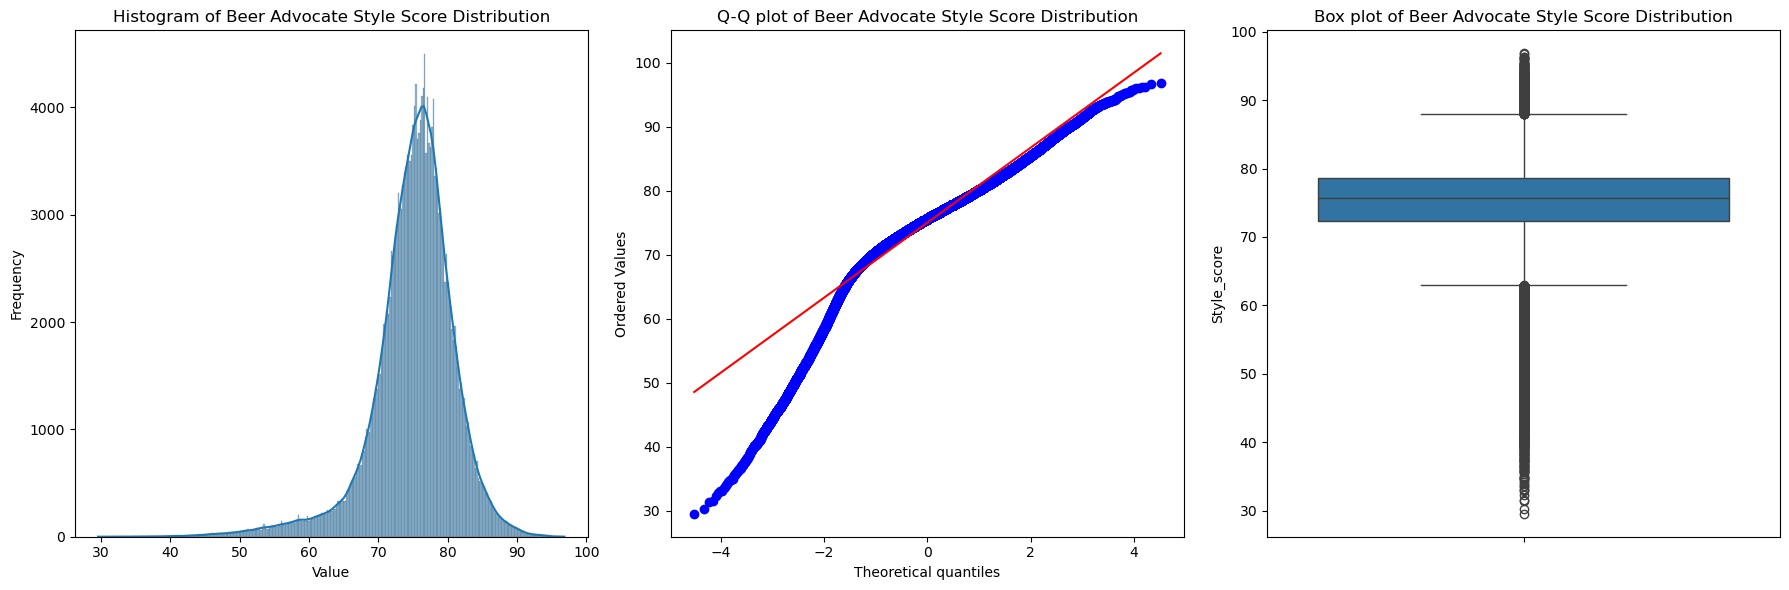

c:\Users\jon\anaconda3\envs\ada\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 216789.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro Test for Dataset 1: Statistic = 0.9284479362123703, p-value = 7.499629894714377e-119


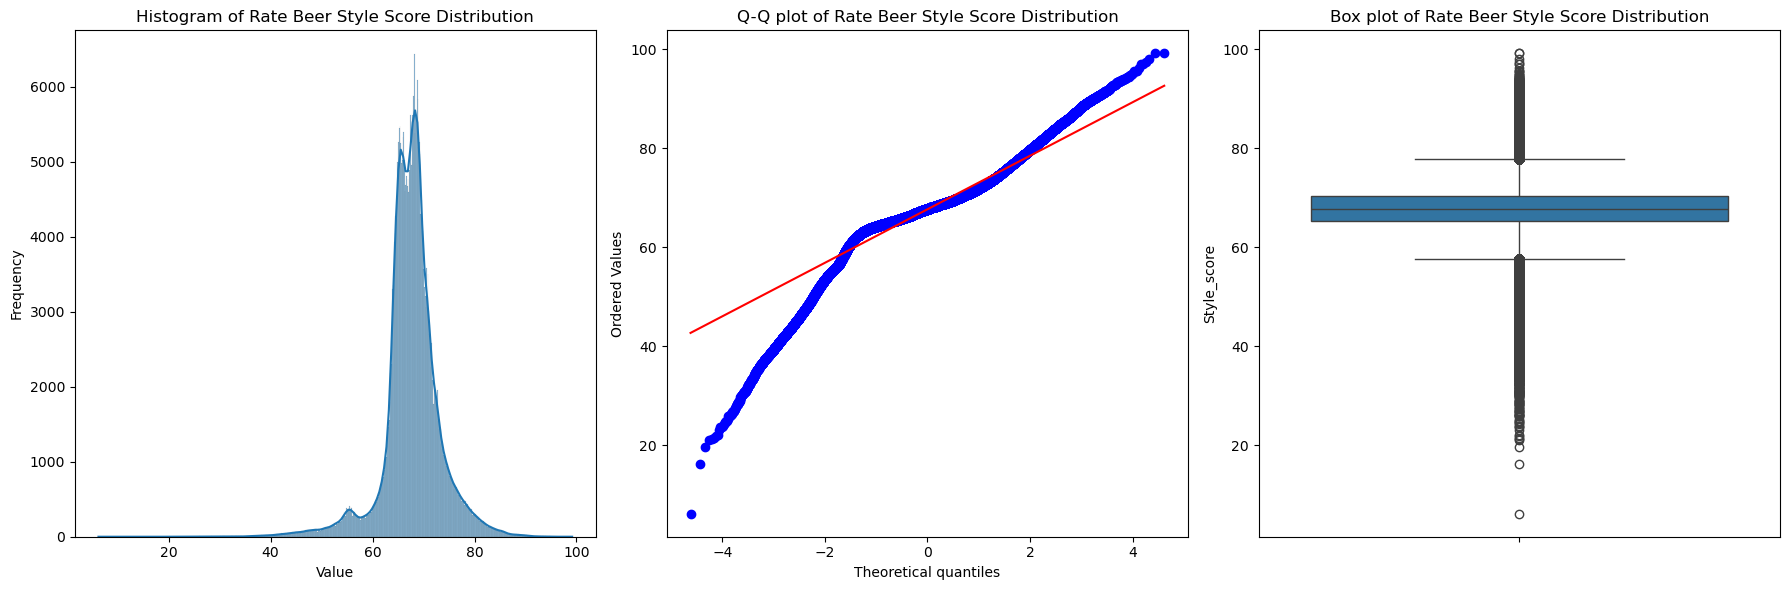

Shapiro Test for Dataset 1: Statistic = 0.9174324049249972, p-value = 2.207400358609631e-132


c:\Users\jon\anaconda3\envs\ada\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 358961.
  res = hypotest_fun_out(*samples, **kwds)


In [28]:
def plot_normality(data, title):
    # Set up the figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Histogram
    sns.histplot(data, kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram of {title}")
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    
    # Q-Q plot
    stats.probplot(data, dist="norm", plot=axes[1])
    axes[1].set_title(f"Q-Q plot of {title}")
    
    # Box plot
    sns.boxplot(data, ax=axes[2])
    axes[2].set_title(f"Box plot of {title}")
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

    stat1, p1 = stats.shapiro(data)
    print(f"Shapiro Test for Dataset 1: Statistic = {stat1}, p-value = {p1}")

plot_normality(beers_adv_col_filt['Style_score'], 'Beer Advocate Style Score Distribution')
plot_normality(beers_rate_col_filt['Style_score'], 'Rate Beer Style Score Distribution')

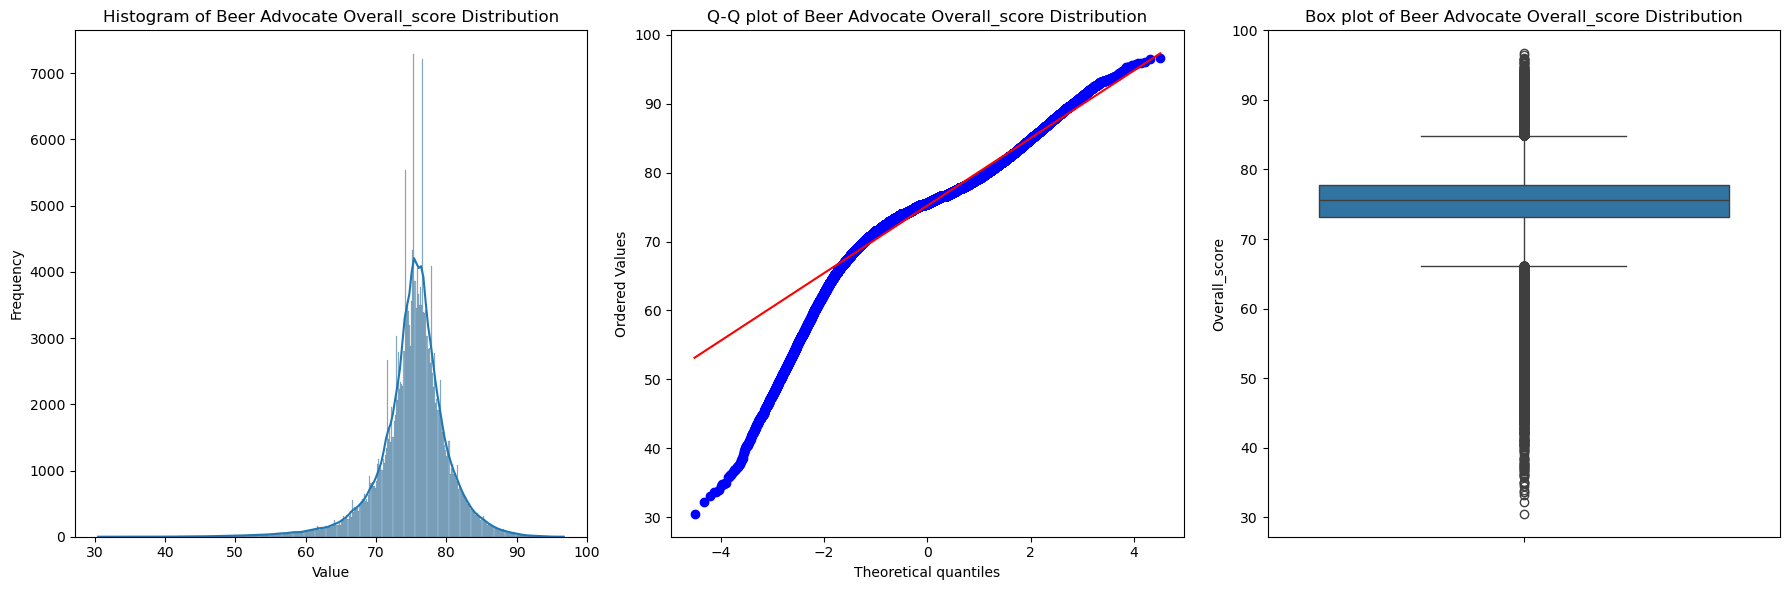

c:\Users\jon\anaconda3\envs\ada\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 216789.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro Test for Dataset 1: Statistic = 0.9284444656580475, p-value = 7.47583208161461e-119


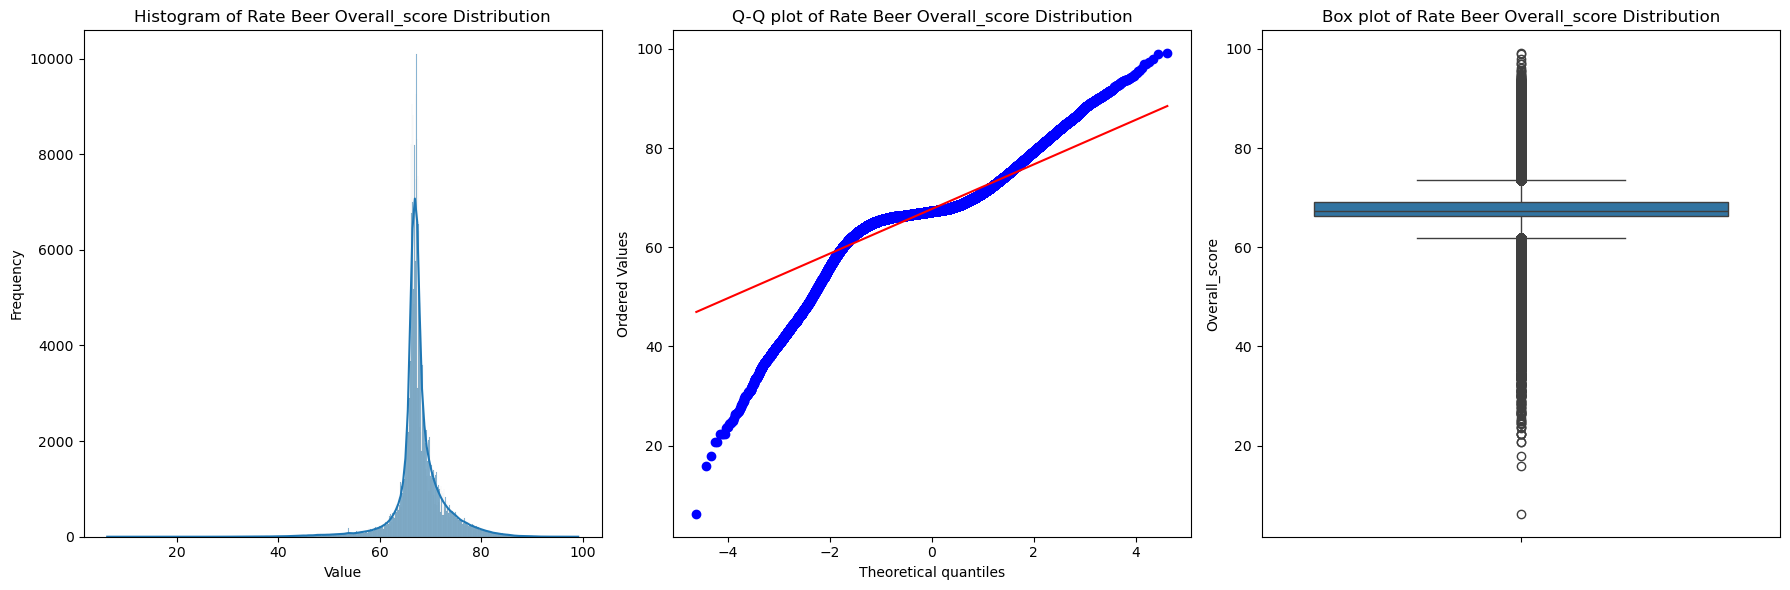

Shapiro Test for Dataset 1: Statistic = 0.8448377630575736, p-value = 4.2052138627639936e-152


c:\Users\jon\anaconda3\envs\ada\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 358961.
  res = hypotest_fun_out(*samples, **kwds)


In [29]:
plot_normality(beers_adv_col_filt['Overall_score'], 'Beer Advocate Overall_score Distribution')
plot_normality(beers_rate_col_filt['Overall_score'], 'Rate Beer Overall_score Distribution')

We can see in th 4 groups of plots how none of the metrics can be considered as normally distributed.

Now as `beer_id` and `brewery_id` might not match along both datasets lets investigate it:

In [30]:
def check_match_percentage(df1, df2):
 
    merged_beer = pd.merge(df1, df2, on='beer_name', suffixes=('_df1', '_df2'))
    merged_brewery = pd.merge(df1, df2, on='brewery_name', suffixes=('_df1', '_df2'))
    
    beer_id_match_percentage = (merged_beer['beer_id_df1'] == merged_beer['beer_id_df2']).mean() * 100
    brewery_id_match_percentage = (merged_brewery['brewery_id_df1'] == merged_brewery['brewery_id_df2']).mean() * 100
    
    return beer_id_match_percentage, brewery_id_match_percentage

In [31]:
beer_id_match, brewery_id_match = check_match_percentage(beers_adv_col_filt, beers_rate_col_filt)
print(f"Beer ID Match Percentage: {beer_id_match}%")
print(f"Brewery ID Match Percentage: {brewery_id_match}%")

Beer ID Match Percentage: 0.0%
Brewery ID Match Percentage: 0.0%


There is no matching at all. For that we will select the ids from the more abundant dataset as baseline, use that for the other dataset, and leave then untouched those that are independent to one dataset.

In [36]:
matching_beer_names = pd.merge(
    beers_adv_col_filt[['beer_name']],
    beers_rate_col_filt[['beer_name','beer_id']],
    on='beer_name'
)
matching_count = len(matching_beer_names)

print(f"Number of matching 'beer_name' entries: {matching_count}")

Number of matching 'beer_name' entries: 15123


In [46]:
beer_id_map = matching_beer_names.set_index('beer_name')['beer_id'].to_dict()
beers_adv_col_filt['beer_id'] = beers_adv_col_filt['beer_name'].map(beer_id_map).fillna(beers_adv_col_filt['beer_id'])

## Data inspection

Initial inspection of data in the merged dataset:

In [7]:
dataset_information(beers, "Global beers matched dataset")



########################################################
We are starting analysing dataset Global beers matched dataset
- Dimension of starting dataset: (28841, 14)
- Columns of dataset:  Index(['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'style',
       'nbr_ratings', 'avg', 'abv', 'zscore', 'location', 'location_region',
       'US', 'UK', 'Canada'],
      dtype='object')
- Are all the id unique? Answer: False
- Are there some values that are NaN inside the dataset? Answer: False
Head: 
    beer_id                      beer_name  brewery_id  \
0   170855         3 Sheeps Cirque Du Wit       14215   
1   222750            3 Sheeps First Kiss       14215   
2   494431           3 Sheeps Fresh Coast       14215   
3   348887          3 Sheeps Happy Summer       14215   
4   182392  3 Sheeps Hello My Name is Joe       14215   

               brewery_name                 style  nbr_ratings       avg  abv  \
0  3 Sheeps Brewing Company               Witbier           34  6.553

## Numerical variables

In [18]:
print("avg\n##########################")
print(beers['avg'].describe())
print("##########################\nnbr_ratings\n##########################")
print(beers['nbr_ratings'].describe())

avg
##########################
count    28841.000000
mean         7.169942
std          0.604204
min          0.000000
25%          6.802721
50%          7.097506
75%          7.505669
max         10.000000
Name: avg, dtype: float64
##########################
nbr_ratings
##########################
count    28841.000000
mean        18.715093
std         97.844607
min          1.000000
25%          2.000000
50%          4.000000
75%         10.000000
max       6844.000000
Name: nbr_ratings, dtype: float64


In [32]:
beers_not_usa = beers[beers['US'] == False]

beers_not_usa.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,avg,abv,zscore,location,location_region,US,UK,Canada


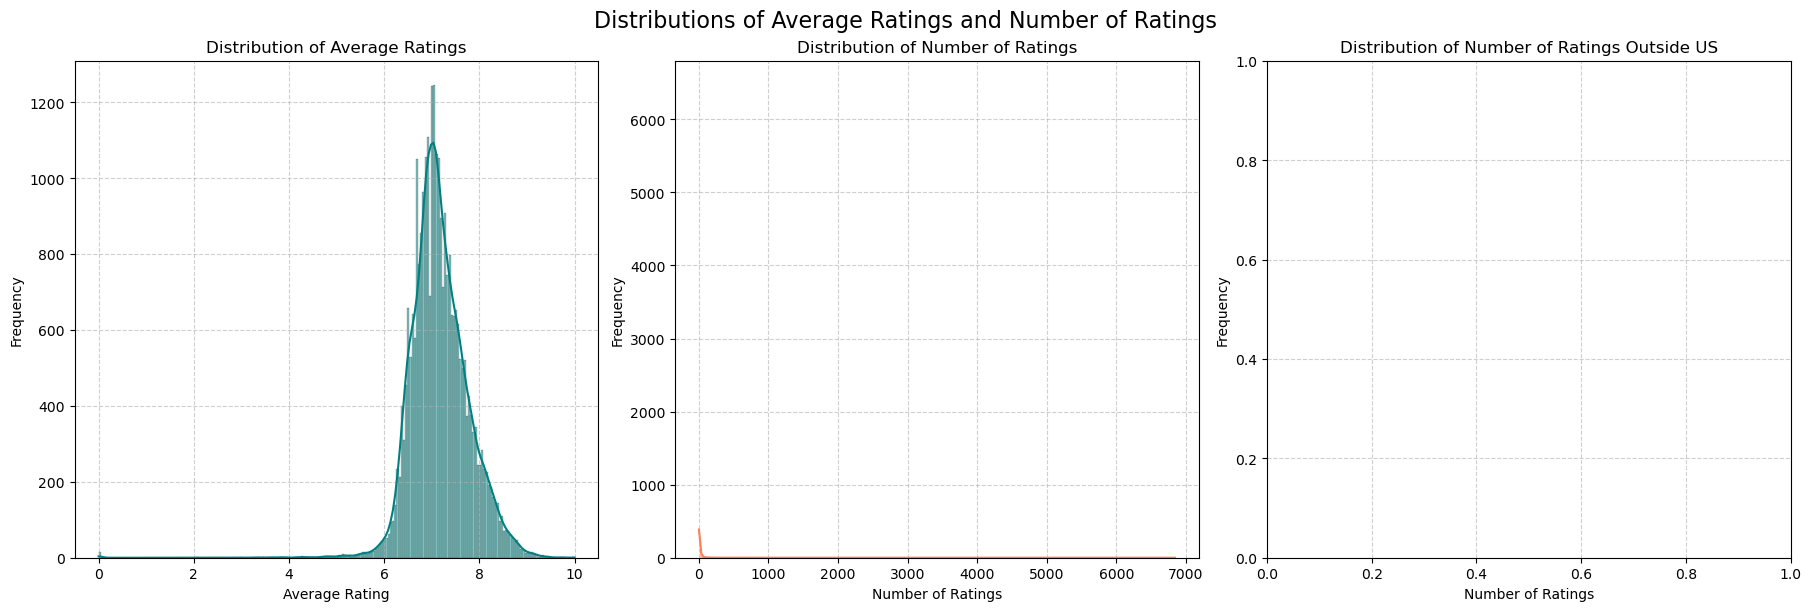

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)


sns.histplot(beers['avg'], kde=True, color='teal', ax=ax1)
ax1.set_title('Distribution of Average Ratings')
ax1.set_xlabel('Average Rating')
ax1.set_ylabel('Frequency')
ax1.grid(True, linestyle='--', alpha=0.6)

sns.histplot(beers['nbr_ratings'], kde=True, color='coral', ax=ax2)
ax2.set_title('Distribution of Number of Ratings')
ax2.set_xlabel('Number of Ratings')
ax2.set_ylabel('Frequency')
ax2.grid(True, linestyle='--', alpha=0.6)

sns.histplot(beers[beers['US'] == False]['nbr_ratings'], kde=True, color='green', ax=ax3)
ax3.set_title('Distribution of Number of Ratings Outside US')
ax3.set_xlabel('Number of Ratings')
ax3.set_ylabel('Frequency')
ax3.grid(True, linestyle='--', alpha=0.6)

fig.suptitle('Distributions of Average Ratings and Number of Ratings', fontsize=16)
plt.show()

In [30]:
beers.sort_values(by='nbr_ratings', ascending=False).head(100)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,avg,abv,zscore,location,location_region,US,UK,Canada
27824,14232,AleSmith Speedway Stout,396,AleSmith Brewing Company,American Double / Imperial Stout,6844,9.085239,12.0,0.878459,United States,California,True,False,False
27972,531,Brooklyn Black Chocolate Stout,45,Brooklyn Brewery,Russian Imperial Stout,6676,8.627859,10.0,0.495761,United States,New York,True,False,False
27986,528,Brooklyn Lager,45,Brooklyn Brewery,American Amber / Red Lager,3643,7.900208,5.2,-0.261546,United States,New York,True,False,False
7444,531,Brooklyn Black Chocolate Stout,90,Brooklyn Brewery,Imperial Stout,3402,9.024943,10.0,1.045310,United States,New York,True,False,False
1194,14232,AleSmith Speedway Stout,432,AleSmith Brewing Company,Imperial Stout,2962,9.750567,12.0,1.568054,United States,California,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28407,154627,Alaskan Freeride APA,429,Alaskan Brewing Co.,American Pale Ale (APA),613,7.858628,5.3,-0.380415,United States,Alaska,True,False,False
28350,169849,West Sixth IPA,28764,West Sixth Brewing Company,American IPA,607,8.170478,7.0,-0.001636,United States,Kentucky,True,False,False
27461,139669,Westbrook India Pale Ale,12402,Westbrook Brewing,India Pale Ale (IPA),604,8.390023,6.8,0.525743,United States,South Carolina,True,False,False
20865,145241,Maine Beer Lunch,10659,Maine Beer Company,India Pale Ale (IPA),599,9.092971,7.0,1.111925,United States,Maine,True,False,False


There are only US beers.

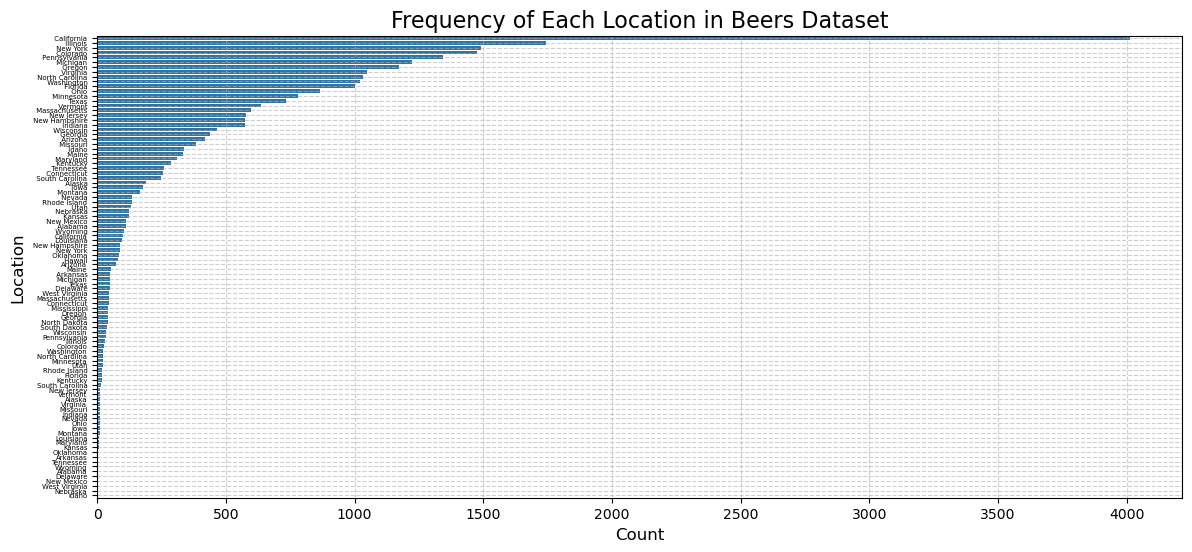

In [41]:
plt.figure(figsize=(14, 6))
sns.barplot(y=beers['location_region'].value_counts().index, 
            x=beers['location_region'].value_counts().values 
            )
plt.title('Frequency of Each Location in Beers Dataset', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Location', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [50]:
state_counts = beers['location_region'].value_counts().reset_index()
state_counts.columns = ['state', 'beer_count']

# Map full state names to abbreviations
us_state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Convert state names to abbreviations
state_counts['state'] = state_counts['state'].map(us_state_abbrev)

# Calculate log scale for better color differentiation
state_counts['log_beer_count'] = np.log1p(state_counts['beer_count'])

# Create an interactive map with Plotly for US states
fig = px.choropleth(
    state_counts,
    locations="state",
    locationmode="USA-states",  # Use 'USA-states' mode to restrict to US states
    color="log_beer_count",     # Log scale column for coloring
    hover_name="state",
    hover_data={
        "beer_count": True  # Display the original number of beers for clarity
    },
    title="Number of Beers per State in the US (Log Scale)"
)

# Update layout for better appearance and focus on the US
fig.update_geos(
    scope="usa",  # Restrict to USA
    showcoastlines=True,
    coastlinecolor="Gray"
)
fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    coloraxis_colorbar={
        'title': "Number of Beers (Log Scale)",
        'tickvals': [np.log1p(val) for val in [1, 10, 100, 1000, 10000, 100000]],  # Log scale ticks
        'ticktext': ['1', '10', '100', '1k', '10k', '100k']
    }
)

# Display the figure
fig.show()
fig.write_html("us_beer_map.html")
